<a href="https://colab.research.google.com/github/stemgene/Predict-Stock-Price-by-LSTM-and-Twitter-Analysis-/blob/master/1_Data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/borisbanushev/stockpredictionai/blob/master/readme.md



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
from pandas_datareader import data
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import urllib.request, json
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import tensorflow as tf
import h5py
import requests
import os
import csv

from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [46]:
stocks = pd.read_csv("/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/S&P500.csv", parse_dates=['Date']).set_index('Date')
df = stocks.loc[:, ['Adj Close']].copy()  #, 'Volume'
df.rename(columns={'Adj Close': "price"}, inplace=True)
df.tail()

,price
Date,
2019-10-25,3022.550049
2019-10-28,3039.419922
2019-10-29,3036.889893
2019-10-30,3046.770020
2019-10-31,3037.560059


In [3]:
len(df.price)

755

In [47]:
# https://plot.ly/python/candlestick-charts/
import plotly.graph_objects as go
from datetime import datetime

fig = go.Figure(data=[go.Candlestick(x=stocks.index,
                open=stocks['Open'],
                high=stocks['High'],
                low=stocks['Low'],
                close=stocks['Adj Close'])])

fig.show()

## 1. Correlated assets

NASDAQ

In [48]:
nasdaq = pd.read_csv("/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/NASDAQ.csv", parse_dates=['Date']).set_index('Date')
df_n = nasdaq.loc[:, ['Adj Close']].copy()
df_n.rename(columns={'Adj Close': "NASDAQ price"}, inplace=True)
df = pd.concat([df, df_n], axis=1, sort=False)
df.shape[0]

755

Russell 2000

In [49]:
russell = pd.read_csv("/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/Russell2000.csv", parse_dates=['Date']).set_index('Date')
df_R = russell.loc[:, ['Adj Close']].copy()
df_R.rename(columns={'Adj Close': "Russell2000 price"}, inplace=True)
df = pd.concat([df, df_R], axis=1, sort=False)
df.shape[0]

755

Dow Jones Indestrial Average

In [50]:
DJI = pd.read_csv("/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/DJI.csv", parse_dates=['Date']).set_index('Date')
df_D = DJI.loc[:, ['Adj Close']].copy()
df_D.rename(columns={'Adj Close': "DJI price"}, inplace=True)
df = pd.concat([df, df_D], axis=1, sort=False)
df.shape[0]

755

SZCZ

Although there is time lag between US and China, China's time will be earlier 12 hours than US, it doesn't necessary to modify the time, since it happens that the price of 11.1 of China can affact to 11.1 of US.

But it need to check whether there is any null value if two forms are joined. Since the trade day may be different. China has Spring Festival and national days which will rest 14 days. But US only has Christmas Days.

In [51]:
SZ = pd.read_csv("/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/SZCZ2.csv", parse_dates=['Date']).set_index('Date')
df_S = SZ.loc[:, ['Close']].copy()
df_S.rename(columns={'Close': "SZCZ price"}, inplace=True)
df_S = df_S.iloc[::-1]
df = df.join(df_S, how='left').fillna(method='ffill')
df.shape[0]

755

In [52]:
HSI = pd.read_csv("/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/^HSI.csv", parse_dates=['Date']).set_index('Date')
df_H = HSI.loc[:, ['Adj Close']].copy()
df_H.rename(columns={'Adj Close': "HSI price"}, inplace=True)
df = df.join(df_H, how='left').fillna(method='ffill')
df.head()

,price,NASDAQ price,Russell2000 price,DJI price,SZCZ price,HSI price
Date,,,,,,
2016-11-01,2111.719971,5153.580078,1177.939941,18037.099609,10796.14,23147.070313
2016-11-02,2097.939941,5105.569824,1162.520020,17959.640625,10692.65,22810.500000
2016-11-03,2088.659912,5058.410156,1156.890015,17930.669922,10743.96,22683.509766
2016-11-04,2085.179932,5046.370117,1163.439941,17888.279297,10702.57,22642.619141
2016-11-07,2131.520020,5166.169922,1192.250000,18259.599609,10695.18,22801.400391


#### Treasury Field 10 years

In [53]:
Treasury = pd.read_csv("/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/TreasuryYield10Years.csv", parse_dates=['Date']).set_index('Date')
df_tr = Treasury.loc[:, ['Adj Close']].copy()
df_tr.rename(columns={'Adj Close': "Treasury 10y"}, inplace=True)
df = df.join(df_tr, how='left').fillna(method='ffill')
df.head()

,price,NASDAQ price,Russell2000 price,DJI price,SZCZ price,HSI price,Treasury 10y
Date,,,,,,,
2016-11-01,2111.719971,5153.580078,1177.939941,18037.099609,10796.14,23147.070313,1.820
2016-11-02,2097.939941,5105.569824,1162.520020,17959.640625,10692.65,22810.500000,1.799
2016-11-03,2088.659912,5058.410156,1156.890015,17930.669922,10743.96,22683.509766,1.812
2016-11-04,2085.179932,5046.370117,1163.439941,17888.279297,10702.57,22642.619141,1.783
2016-11-07,2131.520020,5166.169922,1192.250000,18259.599609,10695.18,22801.400391,1.828


In [54]:
df.isnull().sum()

price                0
NASDAQ price         0
Russell2000 price    0
DJI price            0
SZCZ price           0
HSI price            0
Treasury 10y         0
dtype: int64

## 2. Technical indicators

In [55]:
"""function to create the technical indicators"""

def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['price'].rolling(window=7).mean()
    fill7_price = dataset['price'][:6]
    dataset['ma7'] = dataset.ma7.fillna(fill7_price)
    dataset['ma21'] = dataset['price'].rolling(window=21).mean()
    fill21_price = dataset['price'][:20]
    dataset['ma21'] = dataset.ma21.fillna(fill21_price)
    
    # Create MACD
    #dataset['26ema'] = pd.DataFrame.ewm(dataset['price'], span=26).mean()
    #dataset['12ema'] = pd.DataFrame.ewm(dataset['price'], span=12).mean()
    #dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    # Create Bollinger Bands
    dataset['20sd'] = dataset['price'].rolling(window=20).std()
    dataset['20sd'] = dataset['20sd'].fillna(method='bfill')
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['upper_band'] = dataset.upper_band.fillna(fill21_price)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    dataset['lower_band'] = dataset.lower_band.fillna(fill21_price)
    # Create Exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['price']-1
    
    return dataset

df = get_technical_indicators(df)
df.head()

,price,NASDAQ price,Russell2000 price,DJI price,SZCZ price,HSI price,Treasury 10y,ma7,ma21,20sd,upper_band,lower_band,ema,momentum
Date,,,,,,,,,,,,,,
2016-11-01,2111.719971,5153.580078,1177.939941,18037.099609,10796.14,23147.070313,1.820,2111.719971,2111.719971,40.901838,2193.523646,2029.916296,2111.719971,2110.719971
2016-11-02,2097.939941,5105.569824,1162.520020,17959.640625,10692.65,22810.500000,1.799,2097.939941,2097.939941,40.901838,2179.743616,2016.136266,2101.384948,2096.939941
2016-11-03,2088.659912,5058.410156,1156.890015,17930.669922,10743.96,22683.509766,1.812,2088.659912,2088.659912,40.901838,2170.463587,2006.856237,2092.575308,2087.659912
2016-11-04,2085.179932,5046.370117,1163.439941,17888.279297,10702.57,22642.619141,1.783,2085.179932,2085.179932,40.901838,2166.983607,2003.376257,2087.583429,2084.179932
2016-11-07,2131.520020,5166.169922,1192.250000,18259.599609,10695.18,22801.400391,1.828,2131.520020,2131.520020,40.901838,2213.323695,2049.716345,2116.995527,2130.520020


<Figure size 1600x1000 with 0 Axes>

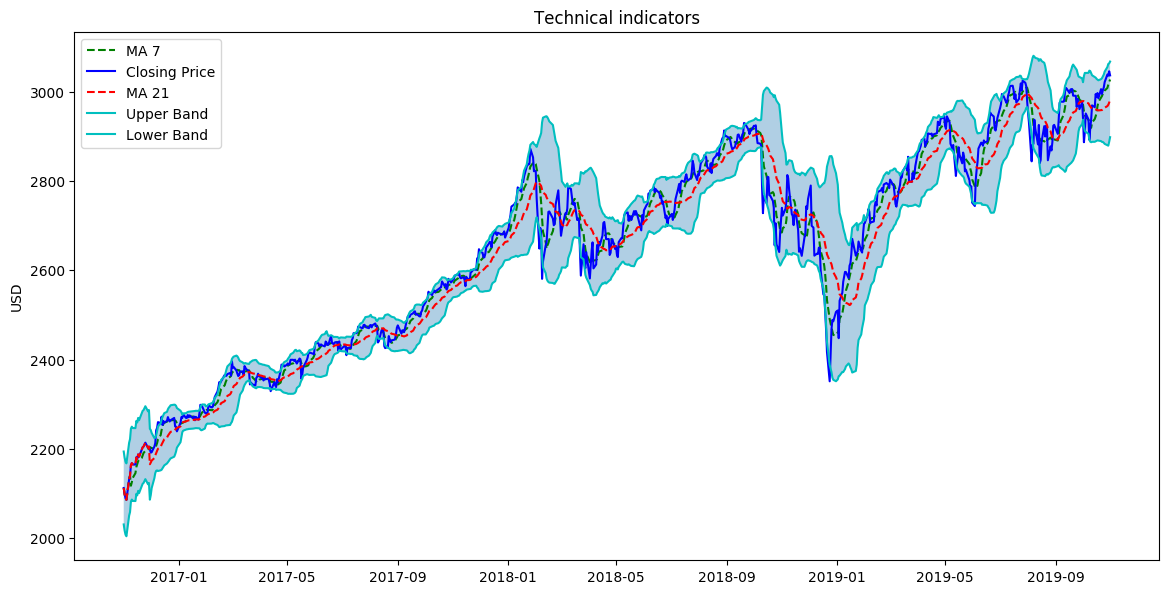

In [56]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.figure(figsize=(14, 7), dpi=100)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators')
    plt.ylabel('USD')
    plt.legend()

    # # Plot second subplot
    # plt.subplot(2, 1, 2)
    # plt.title('MACD')
    # plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    # plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

plot_technical_indicators(df, 1700)

## 3. Fundamental Analysis

### 3.1 Setiment

In [57]:
tweets = pd.read_csv("/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/tweets_score.csv", parse_dates=['date']).set_index('date')
# df_H.rename(columns={'Adj Close': "HSI price"}, inplace=True)
df = df.join(tweets, how='left').fillna(method='ffill')
tweets.head()

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20
date,,,,,,,,,,,,,,,,,,,,
2016-11-01,0.007091,0.007091,0.007091,0.007091,0.393351,0.007091,0.007091,0.007091,0.007091,0.007091,0.007091,0.007091,0.007091,0.007091,0.479020,0.007091,0.007091,0.007091,0.007091,0.007091
2016-11-02,0.004474,0.004474,0.004474,0.004474,0.004474,0.004474,0.004474,0.004474,0.105289,0.004474,0.004474,0.312808,0.004474,0.004474,0.505849,0.004474,0.004474,0.004474,0.004474,0.004474
2016-11-03,0.005235,0.005235,0.005235,0.005235,0.005235,0.005235,0.005235,0.005235,0.122476,0.005235,0.005235,0.005235,0.247380,0.005235,0.541155,0.005235,0.005235,0.005235,0.005235,0.005235
2016-11-04,0.007046,0.007046,0.007046,0.007046,0.007046,0.360031,0.007046,0.007046,0.007046,0.007046,0.007046,0.007046,0.007046,0.007046,0.513145,0.007046,0.007046,0.007046,0.007046,0.007046
2016-11-07,0.004561,0.004561,0.004561,0.004561,0.004561,0.047843,0.004561,0.004561,0.065831,0.004561,0.004561,0.004561,0.004561,0.004561,0.525990,0.287353,0.004561,0.004561,0.004561,0.004561


In [58]:
df.tail()

,price,NASDAQ price,Russell2000 price,DJI price,SZCZ price,HSI price,Treasury 10y,ma7,ma21,20sd,upper_band,lower_band,ema,momentum,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-25,3022.550049,8243.120117,1558.709961,26958.060547,9660.44,26667.390625,1.801,3003.459996,2964.972366,40.567569,3046.107504,2883.837227,3017.565963,3021.550049,0.003745,0.003745,0.003745,0.224122,0.003745,0.003745,0.003745,0.003745,0.123414,0.036808,0.003745,0.003745,0.003745,0.003745,0.555735,0.003745,0.003745,0.003745,0.003745,0.003745
2019-10-28,3039.419922,8325.990234,1571.930054,27090.720703,9801.87,26891.259766,1.853,3009.384277,2968.669027,43.803630,3056.276286,2881.061767,3032.135269,3038.419922,0.002458,0.026832,0.002458,0.002458,0.002458,0.018278,0.002458,0.002458,0.352546,0.002458,0.002458,0.020340,0.002458,0.002458,0.545132,0.002458,0.002458,0.002458,0.002458,0.002458
2019-10-29,3036.889893,8276.849609,1577.069946,27071.460938,9746.03,26786.759766,1.835,3016.625698,2971.533308,45.833728,3063.200764,2879.865852,3035.305018,3035.889893,0.003010,0.003010,0.003010,0.003010,0.003010,0.003010,0.003010,0.003010,0.117821,0.028001,0.003010,0.003010,0.003010,0.003010,0.575353,0.003010,0.003010,0.003010,0.003010,0.230662
2019-10-30,3046.770020,8303.980469,1572.849976,27186.689453,9681.54,26667.710938,1.798,3022.347133,2976.605690,43.989737,3064.585163,2888.626216,3042.948353,3045.770020,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.095284,0.003497,0.003497,0.003497,0.003497,0.003497,0.543884,0.301381,0.003497,0.003497,0.003497,0.003497
2019-10-31,3037.560059,8292.360352,1562.449951,27046.230469,9635.33,26906.720703,1.691,3028.285715,2983.746164,42.422861,3068.591886,2898.900441,3039.356157,3036.560059,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.137043,0.004938,0.004938,0.155346,0.004938,0.004938,0.623659,0.004938,0.004938,0.004938,0.004938,0.004938


### 3.2 Fourier tranforms for trend analysis

Along with the daily closing price, we create Fourier transform in order to generalize several long and short-term trends. Using these transforms we eliminate a lot of movement. Having trend approximations can help the LSTM network pick its prediction trends more accurately.

In [0]:
data_FT = df[['price']].copy()
data_FT['Date'] = df.index

In [0]:
close_fft = np.fft.fft(np.asarray(data_FT['price'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

range(0, 377)


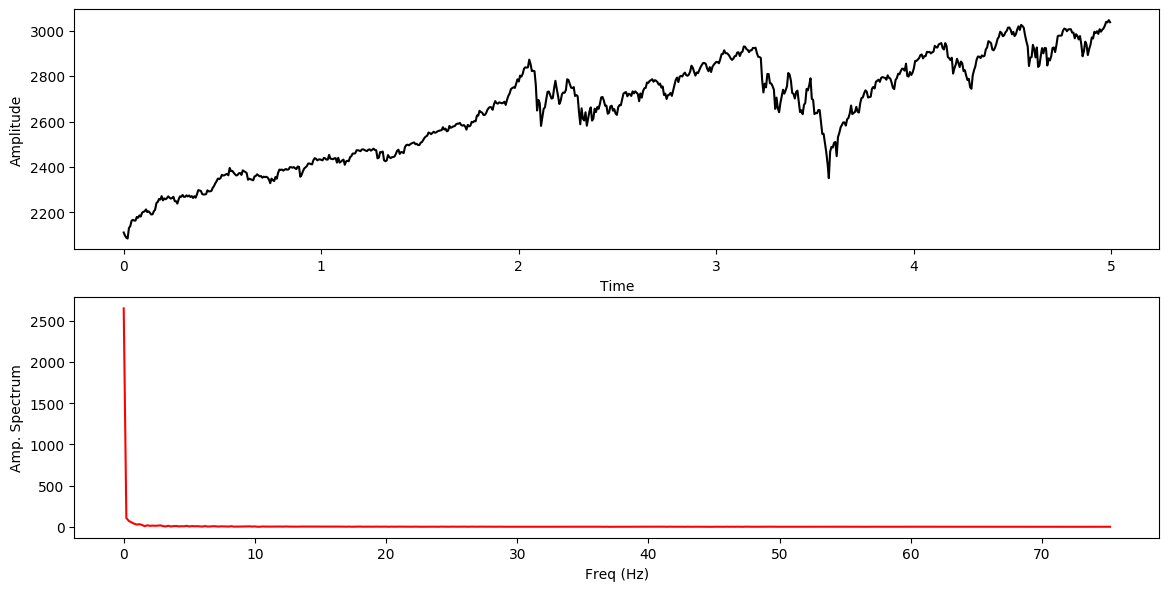

In [61]:
import matplotlib.pyplot as plt 
import numpy as np 
def show(ori_func, ft, sampling_period = 5): 
    n = len(ori_func)
    interval = sampling_period / n 
    plt.figure(figsize=(14, 7), dpi=100)
    plt.subplot(2, 1, 1) 
    plt.plot(np.arange(0, sampling_period, interval), ori_func, 'black') 
    plt.xlabel('Time'), plt.ylabel('Amplitude') 
    plt.subplot(2,1,2) 
    frequency = np.arange(n / 2) / (n * interval) 
    frequency = frequency[:-1]
    print(range(int(n / 2)))
    nfft = abs(ft[range(int(n / 2))] / n ) 
    plt.plot(frequency, nfft, 'red') 
    plt.xlabel('Freq (Hz)'), plt.ylabel('Amp. Spectrum') 
    plt.show() 


show(data_FT['price'], close_fft) 

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning:

Casting complex values to real discards the imaginary part



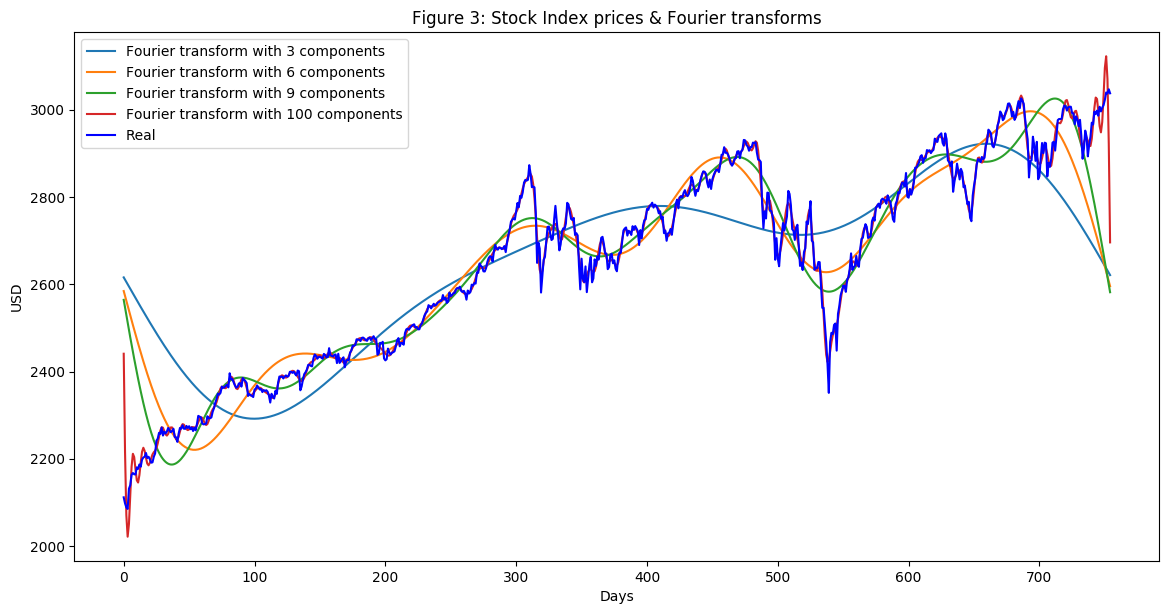

In [62]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10 = np.copy(fft_list); 
    fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(np.asarray(data_FT['price'].tolist()),label='Real', color='b')
plt.xlabel("Days")
plt.ylabel('USD')
plt.title('Figure 3: Stock Index prices & Fourier transforms')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.



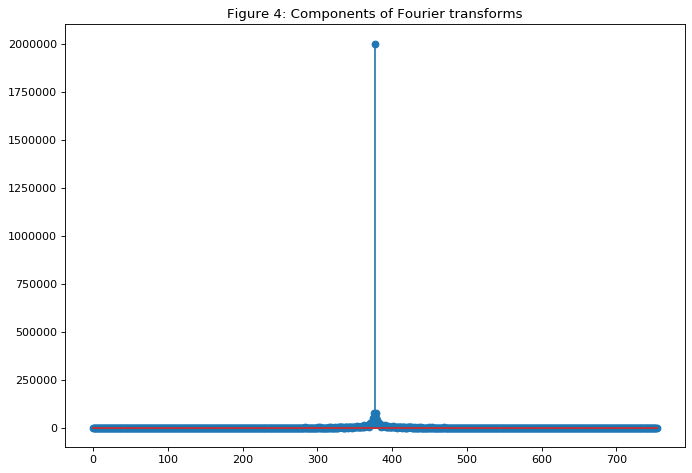

In [63]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [0]:
fft_list = np.asarray(fft_df['fft'].tolist())
fft_temp = np.copy(fft_list)
fft_temp[3:-3] = 0
invers_list = np.fft.ifft(fft_temp)

In [64]:
fft_list = np.asarray(fft_df['fft'].tolist())
fft_dict = {}
for num_ in [3, 6, 9]:
    fft_list_m10 = np.copy(fft_list); 
    fft_list_m10[num_:-num_]=0
    fft_dict[num_] = np.fft.ifft(fft_list_m10)
#df = df.append(fft_dict, ignore_index=True).rename({'3':"FFT 3", '6':"FFT 6", '9':'FFT 9'}, inplace=True)
df["FFT 3"] = fft_dict[3].astype("float32")
df["FFT 6"] = fft_dict[6].astype("float32")
df["FFT 9"] = fft_dict[9].astype("float32")
df.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning:

Casting complex values to real discards the imaginary part

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: ComplexWarning:

Casting complex values to real discards the imaginary part

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: ComplexWarning:

Casting complex values to real discards the imaginary part



,price,NASDAQ price,Russell2000 price,DJI price,SZCZ price,HSI price,Treasury 10y,ma7,ma21,20sd,upper_band,lower_band,ema,momentum,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,FFT 3,FFT 6,FFT 9
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-25,3022.550049,8243.120117,1558.709961,26958.060547,9660.44,26667.390625,1.801,3003.459996,2964.972366,40.567569,3046.107504,2883.837227,3017.565963,3021.550049,0.003745,0.003745,0.003745,0.224122,0.003745,0.003745,0.003745,0.003745,0.123414,0.036808,0.003745,0.003745,0.003745,0.003745,0.555735,0.003745,0.003745,0.003745,0.003745,0.003745,2641.924561,2640.465820,2651.781006
2019-10-28,3039.419922,8325.990234,1571.930054,27090.720703,9801.87,26891.259766,1.853,3009.384277,2968.669027,43.803630,3056.276286,2881.061767,3032.135269,3038.419922,0.002458,0.026832,0.002458,0.002458,0.002458,0.018278,0.002458,0.002458,0.352546,0.002458,0.002458,0.020340,0.002458,0.002458,0.545132,0.002458,0.002458,0.002458,0.002458,0.002458,2636.697754,2629.286133,2634.340576
2019-10-29,3036.889893,8276.849609,1577.069946,27071.460938,9746.03,26786.759766,1.835,3016.625698,2971.533308,45.833728,3063.200764,2879.865852,3035.305018,3035.889893,0.003010,0.003010,0.003010,0.003010,0.003010,0.003010,0.003010,0.003010,0.117821,0.028001,0.003010,0.003010,0.003010,0.003010,0.575353,0.003010,0.003010,0.003010,0.003010,0.230662,2631.462646,2618.078125,2616.828613
2019-10-30,3046.770020,8303.980469,1572.849976,27186.689453,9681.54,26667.710938,1.798,3022.347133,2976.605690,43.989737,3064.585163,2888.626216,3042.948353,3045.770020,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.095284,0.003497,0.003497,0.003497,0.003497,0.003497,0.543884,0.301381,0.003497,0.003497,0.003497,0.003497,2626.220703,2606.852295,2599.279297
2019-10-31,3037.560059,8292.360352,1562.449951,27046.230469,9635.33,26906.720703,1.691,3028.285715,2983.746164,42.422861,3068.591886,2898.900441,3039.356157,3036.560059,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.137043,0.004938,0.004938,0.155346,0.004938,0.004938,0.623659,0.004938,0.004938,0.004938,0.004938,0.004938,2620.973389,2595.619629,2581.727051


### 3.3 ARIMA as a feature

https://www.cnblogs.com/bonelee/p/9523452.html

In [65]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['price']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  754
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3390.225
Method:                       css-mle   S.D. of innovations             21.701
Date:                Mon, 06 Jan 2020   AIC                           6794.451
Time:                        15:31:55   BIC                           6826.828
Sample:                             1   HQIC                          6806.923
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.2248      0.724      1.691      0.091      -0.194       2.644
ar.L1.D.price    -0.0311      0.036     -0.855      0.393      -0.102       0.040
ar.L2.D.price    -0.0438      0.036     

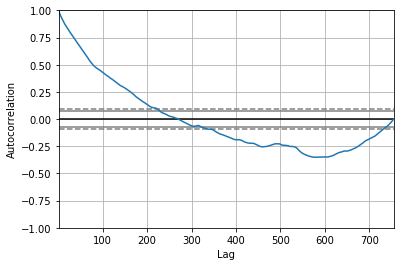

<Figure size 800x560 with 0 Axes>

In [66]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [0]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [68]:
error = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)

Test RMSE: 28.148


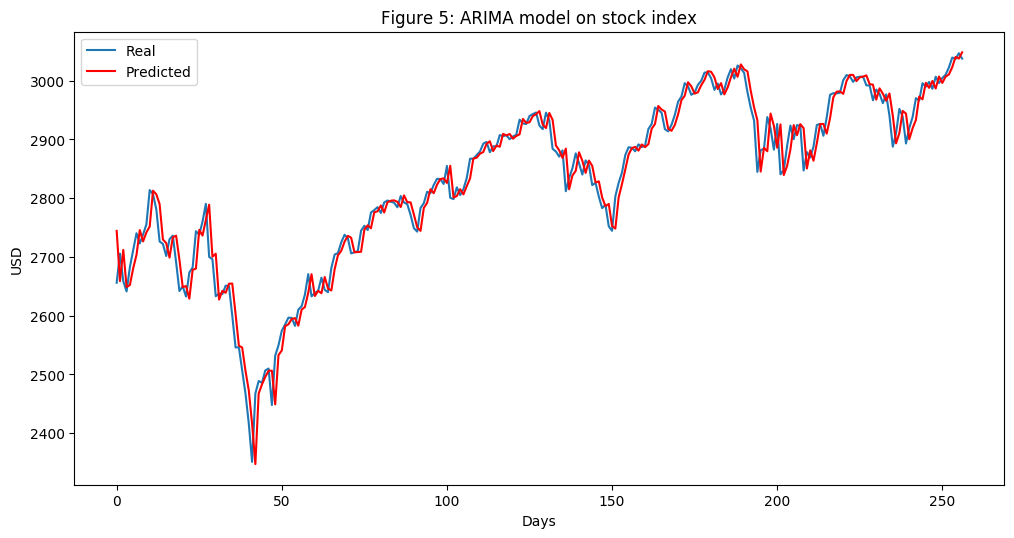

In [69]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on stock index')
plt.legend()
plt.show()

In [70]:
len(predictions)

257

In [0]:
ARIMA_series = np.array([])
pred_ARIMA = np.array(predictions)
#print(len(predictions))
ARIMA_series = np.concatenate((train,pred_ARIMA[:,0]))
df['ARIMA'] = ARIMA_series

In [72]:
df.head()

,price,NASDAQ price,Russell2000 price,DJI price,SZCZ price,HSI price,Treasury 10y,ma7,ma21,20sd,upper_band,lower_band,ema,momentum,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,FFT 3,FFT 6,FFT 9,ARIMA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-11-01,2111.719971,5153.580078,1177.939941,18037.099609,10796.14,23147.070313,1.820,2111.719971,2111.719971,40.901838,2193.523646,2029.916296,2111.719971,2110.719971,0.007091,0.007091,0.007091,0.007091,0.393351,0.007091,0.007091,0.007091,0.007091,0.007091,0.007091,0.007091,0.007091,0.007091,0.479020,0.007091,0.007091,0.007091,0.007091,0.007091,2615.722412,2584.390381,2564.206299,2111.719971
2016-11-02,2097.939941,5105.569824,1162.520020,17959.640625,10692.65,22810.500000,1.799,2097.939941,2097.939941,40.901838,2179.743616,2016.136266,2101.384948,2096.939941,0.004474,0.004474,0.004474,0.004474,0.004474,0.004474,0.004474,0.004474,0.105289,0.004474,0.004474,0.312808,0.004474,0.004474,0.505849,0.004474,0.004474,0.004474,0.004474,0.004474,2610.469238,2573.175537,2546.751709,2097.939941
2016-11-03,2088.659912,5058.410156,1156.890015,17930.669922,10743.96,22683.509766,1.812,2088.659912,2088.659912,40.901838,2170.463587,2006.856237,2092.575308,2087.659912,0.005235,0.005235,0.005235,0.005235,0.005235,0.005235,0.005235,0.005235,0.122476,0.005235,0.005235,0.005235,0.247380,0.005235,0.541155,0.005235,0.005235,0.005235,0.005235,0.005235,2605.215332,2561.985107,2529.397705,2088.659912
2016-11-04,2085.179932,5046.370117,1163.439941,17888.279297,10702.57,22642.619141,1.783,2085.179932,2085.179932,40.901838,2166.983607,2003.376257,2087.583429,2084.179932,0.007046,0.007046,0.007046,0.007046,0.007046,0.360031,0.007046,0.007046,0.007046,0.007046,0.007046,0.007046,0.007046,0.007046,0.513145,0.007046,0.007046,0.007046,0.007046,0.007046,2599.962646,2550.830322,2512.178467,2085.179932
2016-11-07,2131.520020,5166.169922,1192.250000,18259.599609,10695.18,22801.400391,1.828,2131.520020,2131.520020,40.901838,2213.323695,2049.716345,2116.995527,2130.520020,0.004561,0.004561,0.004561,0.004561,0.004561,0.047843,0.004561,0.004561,0.065831,0.004561,0.004561,0.004561,0.004561,0.004561,0.525990,0.287353,0.004561,0.004561,0.004561,0.004561,2594.712402,2539.721436,2495.127686,2131.520020


In [73]:
df.tail()

,price,NASDAQ price,Russell2000 price,DJI price,SZCZ price,HSI price,Treasury 10y,ma7,ma21,20sd,upper_band,lower_band,ema,momentum,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,FFT 3,FFT 6,FFT 9,ARIMA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-25,3022.550049,8243.120117,1558.709961,26958.060547,9660.44,26667.390625,1.801,3003.459996,2964.972366,40.567569,3046.107504,2883.837227,3017.565963,3021.550049,0.003745,0.003745,0.003745,0.224122,0.003745,0.003745,0.003745,0.003745,0.123414,0.036808,0.003745,0.003745,0.003745,0.003745,0.555735,0.003745,0.003745,0.003745,0.003745,0.003745,2641.924561,2640.465820,2651.781006,3010.628819
2019-10-28,3039.419922,8325.990234,1571.930054,27090.720703,9801.87,26891.259766,1.853,3009.384277,2968.669027,43.803630,3056.276286,2881.061767,3032.135269,3038.419922,0.002458,0.026832,0.002458,0.002458,0.002458,0.018278,0.002458,0.002458,0.352546,0.002458,0.002458,0.020340,0.002458,0.002458,0.545132,0.002458,0.002458,0.002458,0.002458,0.002458,2636.697754,2629.286133,2634.340576,3022.869399
2019-10-29,3036.889893,8276.849609,1577.069946,27071.460938,9746.03,26786.759766,1.835,3016.625698,2971.533308,45.833728,3063.200764,2879.865852,3035.305018,3035.889893,0.003010,0.003010,0.003010,0.003010,0.003010,0.003010,0.003010,0.003010,0.117821,0.028001,0.003010,0.003010,0.003010,0.003010,0.575353,0.003010,0.003010,0.003010,0.003010,0.230662,2631.462646,2618.078125,2616.828613,3040.367206
2019-10-30,3046.770020,8303.980469,1572.849976,27186.689453,9681.54,26667.710938,1.798,3022.347133,2976.605690,43.989737,3064.585163,2888.626216,3042.948353,3045.770020,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.095284,0.003497,0.003497,0.003497,0.003497,0.003497,0.543884,0.301381,0.003497,0.003497,0.003497,0.003497,2626.220703,2606.852295,2599.279297,3037.673830
2019-10-31,3037.560059,8292.360352,1562.449951,27046.230469,9635.33,26906.720703,1.691,3028.285715,2983.746164,42.422861,3068.591886,2898.900441,3039.356157,3036.560059,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.137043,0.004938,0.004938,0.155346,0.004938,0.004938,0.623659,0.004938,0.004938,0.004938,0.004938,0.004938,2620.973389,2595.619629,2581.727051,3048.296251


### 3.4 Statistical Checks

https://zhuanlan.zhihu.com/p/21962996

https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/

### 3.5 Feature Engineering

In [74]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0],df.shape[1]))

Total dataset has 755 samples, and 38 features.


In [0]:
df.to_csv('SP500_cleaned.csv')
!cp SP500_cleaned.csv /content/drive/My\ Drive/UR/DSC440_Data_Mining/Project/Data/trained/SP500_cleaned.csv

#### 3.5.1 Feature importance with XGBoost

In [0]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['price']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.85)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(df)


In [77]:
import xgboost as xgb

regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

xgbModel = regressor.fit(X_train_FI,y_train_FI, eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], verbose=False)

eval_result = regressor.evals_result()

training_rounds = range(len(eval_result['validation_0']['rmse']))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[15:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


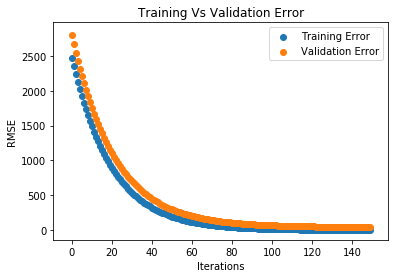

In [78]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

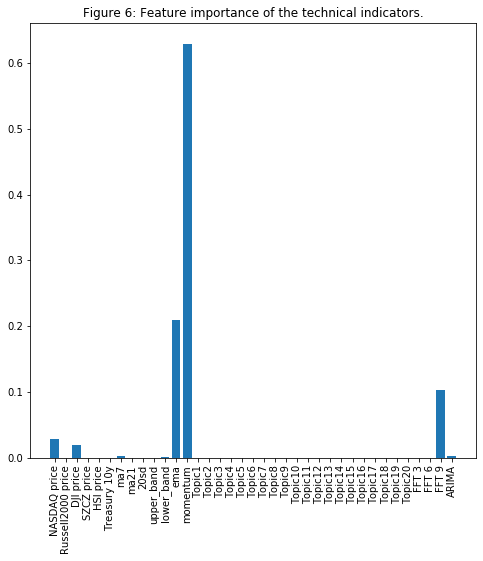

In [79]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

## Data Prepared

### 4.1 Normalization

In [80]:
df.tail()

,price,NASDAQ price,Russell2000 price,DJI price,SZCZ price,HSI price,Treasury 10y,ma7,ma21,20sd,upper_band,lower_band,ema,momentum,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,FFT 3,FFT 6,FFT 9,ARIMA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-25,3022.550049,8243.120117,1558.709961,26958.060547,9660.44,26667.390625,1.801,3003.459996,2964.972366,40.567569,3046.107504,2883.837227,3017.565963,3021.550049,0.003745,0.003745,0.003745,0.224122,0.003745,0.003745,0.003745,0.003745,0.123414,0.036808,0.003745,0.003745,0.003745,0.003745,0.555735,0.003745,0.003745,0.003745,0.003745,0.003745,2641.924561,2640.465820,2651.781006,3010.628819
2019-10-28,3039.419922,8325.990234,1571.930054,27090.720703,9801.87,26891.259766,1.853,3009.384277,2968.669027,43.803630,3056.276286,2881.061767,3032.135269,3038.419922,0.002458,0.026832,0.002458,0.002458,0.002458,0.018278,0.002458,0.002458,0.352546,0.002458,0.002458,0.020340,0.002458,0.002458,0.545132,0.002458,0.002458,0.002458,0.002458,0.002458,2636.697754,2629.286133,2634.340576,3022.869399
2019-10-29,3036.889893,8276.849609,1577.069946,27071.460938,9746.03,26786.759766,1.835,3016.625698,2971.533308,45.833728,3063.200764,2879.865852,3035.305018,3035.889893,0.003010,0.003010,0.003010,0.003010,0.003010,0.003010,0.003010,0.003010,0.117821,0.028001,0.003010,0.003010,0.003010,0.003010,0.575353,0.003010,0.003010,0.003010,0.003010,0.230662,2631.462646,2618.078125,2616.828613,3040.367206
2019-10-30,3046.770020,8303.980469,1572.849976,27186.689453,9681.54,26667.710938,1.798,3022.347133,2976.605690,43.989737,3064.585163,2888.626216,3042.948353,3045.770020,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.095284,0.003497,0.003497,0.003497,0.003497,0.003497,0.543884,0.301381,0.003497,0.003497,0.003497,0.003497,2626.220703,2606.852295,2599.279297,3037.673830
2019-10-31,3037.560059,8292.360352,1562.449951,27046.230469,9635.33,26906.720703,1.691,3028.285715,2983.746164,42.422861,3068.591886,2898.900441,3039.356157,3036.560059,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.137043,0.004938,0.004938,0.155346,0.004938,0.004938,0.623659,0.004938,0.004938,0.004938,0.004938,0.004938,2620.973389,2595.619629,2581.727051,3048.296251


In [81]:
# Pickup same scale column
tech_level_cols = ['Russell2000 price', 'ma7', 'ma21', 'upper_band','lower_band','ema','momentum','FFT 3', 'FFT 6', 'FFT 9','ARIMA'] ###'26ema', '12ema',
MACD_level_cols = ['20sd'] ###'MACD'
ten_thousand_cols = ['NASDAQ price', 'DJI price', 'SZCZ price', 'HSI price']

tech_level_matrix = df.loc[:, tech_level_cols].as_matrix()
MACD_level_matrix = df.loc[:, MACD_level_cols].as_matrix()
ten_thousand_matrix = df.loc[:, ten_thousand_cols].as_matrix()
###volume_level_matrix = df.loc[:, 'Volume'].as_matrix()
treasury_level_matrix = df.loc[:, 'Treasury 10y'].as_matrix()
label_level_matrix = df.loc[:, 'price'].as_matrix()
#price_level_matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [0]:
from sklearn.preprocessing import MinMaxScaler 
# function of normalization
def normalization_2Dmatrix(matrix):
  rows = matrix.shape[0]
  cols = matrix.shape[1]
  reshaped = matrix.reshape(-1, 1)
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(reshaped)
  normalized = scaler.transform(reshaped)
  return normalized.reshape(rows, cols)

def normalization_1Dseries(series):
  reshaped = series.reshape(-1,1)
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(reshaped)
  normalized = scaler.transform(reshaped)
  return normalized.reshape(-1)


tech_normed = normalization_2Dmatrix(tech_level_matrix)
MACD_normed = normalization_2Dmatrix(MACD_level_matrix)
ten_thousand_normed = normalization_2Dmatrix(ten_thousand_matrix)
###volume_normed = normalization_1Dseries(volume_level_matrix)
treasury_normed = normalization_1Dseries(treasury_level_matrix)
label_normed = normalization_1Dseries(label_level_matrix)
#print(price_normed)

In [83]:
df_normed = df.copy()
df_normed[tech_level_cols] = tech_normed
df_normed[MACD_level_cols] = MACD_normed
df_normed[ten_thousand_cols] = ten_thousand_normed
###df_normed['Volume'] = volume_normed
df_normed['Treasury 10y'] = treasury_normed
df_normed['price'] = label_normed
df_normed.head()

,price,NASDAQ price,Russell2000 price,DJI price,SZCZ price,HSI price,Treasury 10y,ma7,ma21,20sd,upper_band,lower_band,ema,momentum,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,FFT 3,FFT 6,FFT 9,ARIMA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-11-01,0.027600,0.003814,0.010937,0.462176,0.204562,0.643975,0.203380,0.496112,0.496112,0.295059,0.538616,0.453608,0.496112,0.495593,0.007091,0.007091,0.007091,0.007091,0.393351,0.007091,0.007091,0.007091,0.007091,0.007091,0.007091,0.007091,0.007091,0.007091,0.479020,0.007091,0.007091,0.007091,0.007091,0.007091,0.757983,0.741703,0.731216,0.496112
2016-11-02,0.013270,0.002106,0.002925,0.459420,0.200880,0.632001,0.191549,0.488952,0.488952,0.295059,0.531456,0.446449,0.490742,0.488433,0.004474,0.004474,0.004474,0.004474,0.004474,0.004474,0.004474,0.004474,0.105289,0.004474,0.004474,0.312808,0.004474,0.004474,0.505849,0.004474,0.004474,0.004474,0.004474,0.004474,0.755253,0.735876,0.722147,0.488952
2016-11-03,0.003619,0.000428,0.000000,0.458390,0.202705,0.627483,0.198873,0.484131,0.484131,0.295059,0.526634,0.441627,0.486165,0.483611,0.005235,0.005235,0.005235,0.005235,0.005235,0.005235,0.005235,0.005235,0.122476,0.005235,0.005235,0.005235,0.247380,0.005235,0.541155,0.005235,0.005235,0.005235,0.005235,0.005235,0.752523,0.730062,0.713130,0.484131
2016-11-04,0.000000,0.000000,0.003403,0.456881,0.201233,0.626028,0.182535,0.482322,0.482322,0.295059,0.524826,0.439819,0.483571,0.481803,0.007046,0.007046,0.007046,0.007046,0.007046,0.360031,0.007046,0.007046,0.007046,0.007046,0.007046,0.007046,0.007046,0.007046,0.513145,0.007046,0.007046,0.007046,0.007046,0.007046,0.749794,0.724266,0.704183,0.482322
2016-11-07,0.048191,0.004262,0.018372,0.470092,0.200970,0.631677,0.207887,0.506400,0.506400,0.295059,0.548904,0.463896,0.498853,0.505880,0.004561,0.004561,0.004561,0.004561,0.004561,0.047843,0.004561,0.004561,0.065831,0.004561,0.004561,0.004561,0.004561,0.004561,0.525990,0.287353,0.004561,0.004561,0.004561,0.004561,0.747066,0.718494,0.695324,0.506400


In [0]:
df_normed.to_csv('SP500_normed.csv')
!cp SP500_normed.csv /content/drive/My\ Drive/UR/DSC440_Data_Mining/Project/Data/trained/SP500_normed.csv

### 4.2 Split time series dataset

In [85]:
from sklearn.model_selection import train_test_split

def build_timeseries(df_normed, time_steps, label_col_index=0):
  normed_matrix = df_normed.as_matrix()
  dim_0 = normed_matrix.shape[0] - time_steps
  dim_1 = normed_matrix.shape[1]
  X = np.zeros((dim_0, time_steps, dim_1))
  y = np.zeros((dim_0,))

  for i in range(dim_0):
    X[i] = normed_matrix[i:time_steps+i]
    y[i] = normed_matrix[time_steps+i, label_col_index]
  print("length of time-series i/o",X.shape,y.shape)
  return X, y

time_steps = 5
X, price_normed = build_timeseries(df_normed, time_steps)
# split into train, valid, test sets
X_train, X_test, y_train, y_test = train_test_split(X, price_normed, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, shuffle=False)
print("X_train's shape:", X_train.shape)
print("y_train's shape:", y_train.shape)
print("X_val's shape:", X_val.shape)
print("y_val's shape:", y_val.shape)
print("X_test's shape:", X_test.shape)
print("y_test's shape:", y_test.shape)

length of time-series i/o (750, 5, 38) (750,)
X_train's shape: (522, 5, 38)
y_train's shape: (522,)
X_val's shape: (115, 5, 38)
y_val's shape: (115,)
X_test's shape: (113, 5, 38)
y_test's shape: (113,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



#### Save data sets to files, and other models can use it.

The dataset is 3D dimension, need to be convert to 1-D to save.
https://github.com/stemgene/Python-Diary/blob/master/Code_question.ipynb

In [0]:
X_train_1d = np.ravel(X_train)
X_val_1d = np.ravel(X_val)
X_test_1d = np.ravel(X_test)
np.savetxt("X_train_522_5_39.csv", X_train_1d, delimiter=",")
!cp X_train_522_5_39.csv /content/drive/My\ Drive/UR/DSC440_Data_Mining/Project/Data/trained/X_train_522_5_39.csv
np.savetxt("X_val_115_5_39.csv", X_val_1d, delimiter=",")
!cp X_val_115_5_39.csv /content/drive/My\ Drive/UR/DSC440_Data_Mining/Project/Data/trained/X_val_115_5_39.csv
np.savetxt("X_test_113_5_39.csv", X_test_1d, delimiter=",")
!cp X_test_113_5_39.csv /content/drive/My\ Drive/UR/DSC440_Data_Mining/Project/Data/trained/X_test_113_5_39.csv
np.savetxt("y_train.csv", y_train, delimiter=",")
!cp y_train.csv /content/drive/My\ Drive/UR/DSC440_Data_Mining/Project/Data/trained/y_train.csv
np.savetxt("y_val.csv", y_val, delimiter=",")
!cp y_val.csv /content/drive/My\ Drive/UR/DSC440_Data_Mining/Project/Data/trained/y_val.csv
np.savetxt("y_test.csv", y_test, delimiter=",")
!cp y_test.csv /content/drive/My\ Drive/UR/DSC440_Data_Mining/Project/Data/trained/y_test.csv
np.savetxt("label_level_matrix.csv", label_level_matrix, delimiter=",")  # for denormalizing during evaluation
!cp label_level_matrix.csv /content/drive/My\ Drive/UR/DSC440_Data_Mining/Project/Data/trained/label_level_matrix.csv
